In [1]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from core.ODEDataset import ODEDataset
from utils import cleaning

import tensorflow as tf
from matplotlib import pyplot as plt

Let's load the dataset and  select the columns we want to use as features and labels.

## Dataset and Feature Selection

In [2]:
dataset = ODEDataset("Dataset")
dataset.from_csv("./playground/data/combined_dataset_cleaned.csv")


In [3]:
OUTPUT = "Presence_TV"

In [4]:
dataset.value_counts(OUTPUT)

Presence_TV
 0.0    8809
 1.0    1907
-1.0       2
Name: count, dtype: int64

### Categorized Features

In [5]:
categorized_features = ['Education_level_HHH',
                        'Socio_status_HHH',
                        'Tariff_payment_frequency',
                        'HH_with_home_business',
                        'Ownership_motorized_vehicle',
                        'Ownership_small_livestock',
                        'Ownership_large_livestock',
                        'Clean_fuel',
                        ]

for feature in categorized_features:
    dataset = dataset.apply(cleaning.add_one_hot_encoding(feature))

dataset.preview()

,Unnamed: 0,ID,Years_of_HHH_in_community,Dwelling_quality_index,Hours_available_electricity,Measurement_age,Monthly_expenditure,Number_of_rooms,Climate_zone_lev_1,Climate_zone_lev_2,...,Ownership_motorized_vehicle_missing,Ownership_small_livestock_No,Ownership_small_livestock_Yes,Ownership_small_livestock_missing,Ownership_large_livestock_No,Ownership_large_livestock_Yes,Ownership_large_livestock_missing,Clean_fuel_No,Clean_fuel_Yes,Clean_fuel_missing
0,0,1001_3,-1,0,-1,-1.0,63600.0,3,3.0,-1.0,...,False,False,True,False,True,False,False,True,False,False
1,1,1001_3,-1,0,-1,-1.0,63600.0,3,3.0,-1.0,...,False,False,True,False,True,False,False,True,False,False
2,2,1026_3,20,0,-1,-1.0,65400.0,3,3.0,3.0,...,False,False,True,False,False,True,False,True,False,False
3,3,1026_3,20,0,-1,-1.0,65400.0,3,3.0,3.0,...,False,False,True,False,False,True,False,True,False,False
4,4,1027_2,15,0,-1,-1.0,-1.0,2,3.0,3.0,...,False,False,True,False,False,True,False,True,False,False


In [6]:
dataset.get_columns()

['Unnamed: 0',
 'ID',
 'Years_of_HHH_in_community',
 'Dwelling_quality_index',
 'Hours_available_electricity',
 'Measurement_age',
 'Monthly_expenditure',
 'Number_of_rooms',
 'Climate_zone_lev_1',
 'Climate_zone_lev_2',
 'Age_HHH',
 'Number_adults',
 'Presence_refrigerator/freezer',
 'Presence_iron',
 'Presence_fan',
 'Presence_DVD_player',
 'Presence_radio/stereo',
 'Presence_phone_charger',
 'Presence_TV',
 'Years_of_HHH_in_community_missing',
 'Dwelling_quality_index_missing',
 'Hours_available_electricity_missing',
 'Measurement_age_missing',
 'Monthly_expenditure_missing',
 'Number_of_rooms_missing',
 'Climate_zone_lev_1_missing',
 'Climate_zone_lev_2_missing',
 'Age_HHH_missing',
 'Number_adults_missing',
 "Education_level_HHH_Bachelor's or equivalent level",
 'Education_level_HHH_Doctoral or equivalent level',
 'Education_level_HHH_Lower secondary education',
 "Education_level_HHH_Master's or equivalent level",
 'Education_level_HHH_No schooling',
 'Education_level_HHH_Not else

### Features Selection

In [7]:
dataset.get_columns()

['Unnamed: 0',
 'ID',
 'Years_of_HHH_in_community',
 'Dwelling_quality_index',
 'Hours_available_electricity',
 'Measurement_age',
 'Monthly_expenditure',
 'Number_of_rooms',
 'Climate_zone_lev_1',
 'Climate_zone_lev_2',
 'Age_HHH',
 'Number_adults',
 'Presence_refrigerator/freezer',
 'Presence_iron',
 'Presence_fan',
 'Presence_DVD_player',
 'Presence_radio/stereo',
 'Presence_phone_charger',
 'Presence_TV',
 'Years_of_HHH_in_community_missing',
 'Dwelling_quality_index_missing',
 'Hours_available_electricity_missing',
 'Measurement_age_missing',
 'Monthly_expenditure_missing',
 'Number_of_rooms_missing',
 'Climate_zone_lev_1_missing',
 'Climate_zone_lev_2_missing',
 'Age_HHH_missing',
 'Number_adults_missing',
 "Education_level_HHH_Bachelor's or equivalent level",
 'Education_level_HHH_Doctoral or equivalent level',
 'Education_level_HHH_Lower secondary education',
 "Education_level_HHH_Master's or equivalent level",
 'Education_level_HHH_No schooling',
 'Education_level_HHH_Not else

In [8]:
Features = [
    #    'Education_level_HHH',
    'Education_level_HHH_Doctoral or equivalent level',
    'Education_level_HHH_Lower secondary education',
    "Education_level_HHH_Master's or equivalent level",
    'Education_level_HHH_No schooling',
    'Education_level_HHH_Not elsewhere classified',
    'Education_level_HHH_Other',
    'Education_level_HHH_Post-secondary non-tertiary education',
    'Education_level_HHH_Primary education',
    'Education_level_HHH_Secondary education',
    'Education_level_HHH_Short-cycle tertiary education',
    'Education_level_HHH_Upper secondary education',
    # 'Socio_status_HHH',
    'Socio_status_HHH_Employee', 'Socio_status_HHH_Employee farm',
    'Socio_status_HHH_Employee non-farm', 'Socio_status_HHH_Employer',
    'Socio_status_HHH_Other', 'Socio_status_HHH_Own-account worker farm',
    'Socio_status_HHH_Own-account worker non-farm',
    'Socio_status_HHH_Unemployed',
    'Socio_status_HHH_Worker not classifiable by status',
    # 'Tariff_payment_frequency',
    'Tariff_payment_frequency_Every 3 months',
    'Tariff_payment_frequency_Every 6 months',
    'Tariff_payment_frequency_Monthly', 'Tariff_payment_frequency_No bill',
    'Tariff_payment_frequency_Other', 'Tariff_payment_frequency_Weekly',

    'HH_with_home_business_Yes',
    'HH_with_home_business_No',
    'HH_with_home_business_missing',

    'Ownership_motorized_vehicle_Yes',
    'Ownership_large_livestock_No',
    'Ownership_motorized_vehicle_missing',

    'Ownership_small_livestock_Yes',
    'Ownership_small_livestock_No',
    'Ownership_small_livestock_missing',

    'Ownership_large_livestock_Yes',
    'Ownership_large_livestock_No',
    'Ownership_large_livestock_missing',

    'Clean_fuel_Yes',
    'Clean_fuel_No',
    'Clean_fuel_missing',

    'Years_of_HHH_in_community',
    'Years_of_HHH_in_community_missing',

    'Dwelling_quality_index',
    'Dwelling_quality_index_missing',

    'Hours_available_electricity',
    'Hours_available_electricity_missing',

    'Measurement_age',
    'Measurement_age_missing',

    'Monthly_expenditure',
    'Monthly_expenditure_missing',

    'Number_of_rooms',
    'Number_of_rooms_missing',
    'Climate_zone_lev_1',
    'Climate_zone_lev_1_missing',

    'Climate_zone_lev_2',
    'Climate_zone_lev_2_missing',

    'Age_HHH',
    'Age_HHH_missing',

    'Number_adults',
    'Number_adults_missing'
]

FEATURE_NUM = len(Features)

In [9]:
dataset = dataset.apply(cleaning.remove_row(OUTPUT, -1))
dataset.value_counts(OUTPUT)

Presence_TV
0.0    8809
1.0    1907
Name: count, dtype: int64

In [10]:
total = len(dataset)
positive = dataset.value_counts(OUTPUT)[1]
negative = total - positive

print(f"Positive: {positive/total}, Negative: {negative/total}")


Positive: 0.17795819335572974, Negative: 0.8220418066442703


In [11]:
dataset = dataset.to_tf_dataset(Features, [OUTPUT])

## Constants and dataset splitting

In [12]:
BATCH_SIZE = 8
EPOCHS = 30
OPTIMIZER = tf.keras.optimizers.Adam(0.001)
LOSS = tf.keras.losses.BinaryCrossentropy()
LEN = len(dataset) // BATCH_SIZE
train_len = int(0.6 * LEN)
val_size = int(0.1 * LEN)
test_size = int(0.1 * LEN)

In [13]:
from collections import Counter
def get_class_distribution(data):

    # Extract all labels from the dataset
    all_labels = []

    for _, label in data:  # Iterate over the dataset
        all_labels.append(label.numpy())  # Convert label tensors to NumPy arrays

    # Flatten the list in case labels are multi-dimensional
    all_labels = [i[0] for k in all_labels for i in list(k)]
    # Count occurrences of each label
    label_counts = Counter(all_labels)

    # Calculate the ratio for each label
    total_samples = sum(label_counts.values())
    label_ratios = {label: count / total_samples for label, count in label_counts.items()}

    # Print out the labels and their ratios
    print("Label Counts:", label_counts)
    print("Label Ratios:", label_ratios)



In [14]:
ds = dataset.shuffle(9001).batch(BATCH_SIZE)

train_ds = ds.take(train_len)
val_ds = ds.skip(train_len).take(val_size)
test_ds = ds.skip(train_len + val_size).take(test_size)


we want to shuffle until we get a good distribution of the classes

In [15]:
print("Training")
get_class_distribution(train_ds)
print("Validation")
get_class_distribution(val_ds)
print("Testing")
get_class_distribution(test_ds)

Training
Label Counts: Counter({0.0: 5271, 1.0: 1153})
Label Ratios: {0.0: 0.8205168119551681, 1.0: 0.17948318804483188}
Validation
Label Counts: Counter({0.0: 862, 1.0: 202})
Label Ratios: {0.0: 0.8101503759398496, 1.0: 0.18984962406015038}
Testing
Label Counts: Counter({0.0: 879, 1.0: 185})
Label Ratios: {0.0: 0.8261278195488722, 1.0: 0.17387218045112782}


## Model

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(FEATURE_NUM,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy', 'precision', 'recall'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,577 (96.00 KB)

 Trainable params: 24,577 (96.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(train_ds, epochs=EPOCHS,

                    validation_data=val_ds)


Epoch 1/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7109 - loss: 551.0551 - precision: 0.2792 - recall: 0.4243 - val_accuracy: 0.7613 - val_loss: 118.3438 - val_precision: 0.3949 - val_recall: 0.6596
Epoch 2/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7918 - loss: 206.8011 - precision: 0.3947 - recall: 0.4297 - val_accuracy: 0.8130 - val_loss: 952.4619 - val_precision: 0.2727 - val_recall: 0.0317
Epoch 3/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7675 - loss: 105.4680 - precision: 0.3491 - recall: 0.4709 - val_accuracy: 0.8064 - val_loss: 29.5336 - val_precision: 0.4783 - val_recall: 0.0537
Epoch 4/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8217 - loss: 31.1515 - precision: 0.4919 - recall: 0.3751 - val_accuracy: 0.7585 - val_loss: 40.1262 - val_precision: 0.4421 - val_recall: 0.8990
Epoch 5/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8154 - loss: 14.9445 - precision: 0.4731 - recall: 0.5125 - val_accuracy: 0.8327 

## Visualization

Text(0.5, 0, 'Epoch')

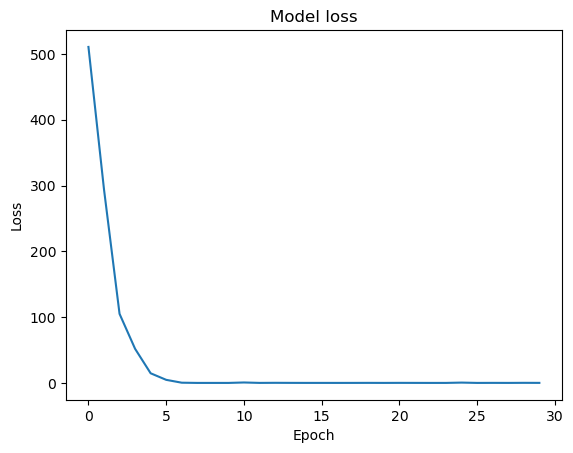

In [18]:

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

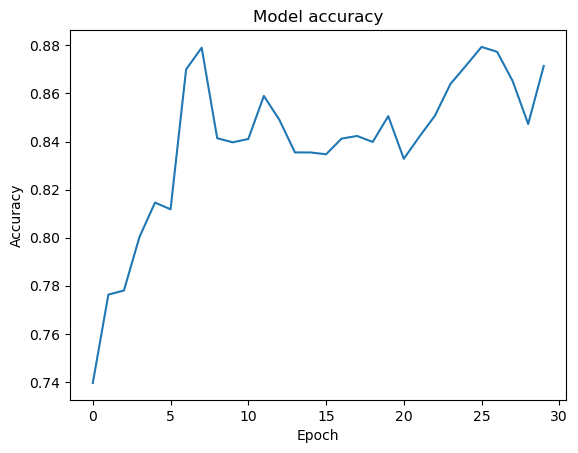

In [19]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [20]:
result = model.evaluate(test_ds)

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.2540 - precision: 0.8410 - recall: 0.4554


In [21]:
print(result)

[0.2427227944135666, 0.8956766724586487, 0.8198198080062866, 0.5]
